In [29]:
import math

from IPython.display import display
import json
import pandas as pd
import os

from pathlib import Path

dirname = os.path.dirname(os.getcwd())
cluster_folders = ["GpResults\\CANNOTMOVERESULTS"]
cluster_folders = [os.path.join(dirname, folder) for folder in cluster_folders]
num_battles = 10
pop_size = 10
total_battles = num_battles * (pop_size - 1)

C:\Users\Caspian\Research\MIT\i-hate-github


In [30]:
def get_df(file):
    with open(file) as f:
        results = json.load(f)
        return pd.json_normalize(results)

In [31]:
def get_gp_result_files():
    for folder in cluster_folders:
        return [str(f) for f in Path(folder).rglob('gpResults*.json')]


In [32]:
def seperate_by_generation_across_all_runs(dfs):
    num_generations = len(dfs[0].generations[0])
    for i in range(len(dfs)):
        df = dfs[i]
        df_gens = len(df.generations[0])
        if df_gens != num_generations:
            raise Exception(f"Number of generations for df {i} is {df_gens}, not {num_generations}!")

    fitnesses_across_all_generations_and_runs = []

    for i in range(num_generations):
        #fitnessesForGeneration = []
        ith_generation_per_run = [(pd.DataFrame(df.generations[0])).iloc[i] for df in dfs]
        merged = []
        for gen in ith_generation_per_run:
            pop = pd.DataFrame(gen.population) # TODO why zeroth index?
            fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
            merged.extend(fitnesses)
            #print(ind)
        fitnesses_across_all_generations_and_runs.append(pd.DataFrame(merged))
    return fitnesses_across_all_generations_and_runs

In [33]:
def runs_with_number_in_dim(dfs, n, dim):
    included_runs = []
    for df in dfs:
        for fitnesses in get_fitnesses_per_gen(df):
            any_equal_num_in_dim = any([math.isclose(int(f[dim]), int(n)) for f in fitnesses])
            if any_equal_num_in_dim:
                included_runs.append(df)

    return included_runs

In [34]:
def get_fitnesses_per_gen(df):
    for pop in pd.DataFrame(df.generations[0]).population:
        pop = pd.DataFrame(pop)
        fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
        yield fitnesses

def get_fitnesses_across_all_runs_flat(dfs):
    all_fitnesses = []
    for df in dfs:
        for pop in pd.DataFrame(df.generations[0]).population:
            pop = pd.DataFrame(pop)
            fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
            all_fitnesses.extend(fitnesses)
    return all_fitnesses

In [35]:
def get_data_normalized(dfs):
    f_data = []
    for df in dfs:
        gens = []
        for gen in pd.DataFrame(df.generations[0]).population:
            pop = []
            # display(pd.DataFrame(gen))
            for ind in pd.DataFrame(gen).fitness:
                ind = ind['lexicographicFitness']
                ind[2] *= total_battles
                ind[4] *= total_battles
                ind[2] /= ind[0]
                ind[4] /= total_battles - ind[0]
                pop.append(ind)
            gens.append(pop)
        f_data.append(gens)
    return f_data

In [36]:
files = get_gp_result_files()
data = [get_df(f) for f in files]
print(len(files))
by_generation_merged = seperate_by_generation_across_all_runs(data)

8


In [37]:

def separate_by_generation_and_dimension(fitness_by_generation_merged):
    by_dimension_and_generations = []
    dim_v = fitness_by_generation_merged[0].shape[1] # get the dimension of the fitness vector (5 in our case)
    print(dim_v)
    for dim in range(dim_v):
        single_dimension_for_all_generations = []  # get a list of all values for each dimension across each generation
        for gen in fitness_by_generation_merged:  # loop through each generation and look at each fitness vector
            dim_values = gen.loc[:, dim]  # get the values at the current dimension for each individual in the generation we are looking at
            num_victories = gen.loc[:, 0]  # get the number of victories for each individual in this generation
            if dim == 2:  # if the dimension is Turns To Win
                dim_values = dim_values * total_battles / num_victories
            elif dim == 4:  # if the dimension is Turn To Lose
                num_losses = num_victories.apply(lambda x: total_battles - x) # take the number of victories for each individual and subtract that from the total number of battles
                dim_values = dim_values * total_battles / num_losses

            single_dimension_for_all_generations.append(dim_values)
        df = pd.DataFrame(single_dimension_for_all_generations)
        df.index = list(range(len(fitness_by_generation_merged)))
        by_dimension_and_generations.append(df)
    return by_dimension_and_generations


In [38]:
seperated = separate_by_generation_and_dimension(by_generation_merged)

5


In [39]:
seperated[2].T.min()

0     368.733333
1     419.736842
2     419.736842
3     407.690909
4     419.736842
5     419.736842
6     419.736842
7     419.736842
8     419.736842
9     419.736842
10    419.736842
11    419.736842
12    419.736842
13    419.736842
14    419.736842
15    419.736842
16    419.736842
17    419.736842
18    419.736842
19    419.736842
20    419.736842
dtype: float64

In [40]:
for i in range(len(seperated)):
    display(seperated[i].T.mean())

0     44.8500
1     52.7125
2     51.9750
3     53.3125
4     52.1625
5     52.1750
6     52.4875
7     52.3625
8     52.0125
9     52.9125
10    52.5500
11    52.5500
12    52.1000
13    52.4500
14    52.5750
15    52.2750
16    52.1625
17    52.7250
18    52.4375
19    52.5875
20    52.1375
dtype: float64

0     0.0750
1     0.0250
2     0.0250
3     0.0125
4     0.0125
5     0.0125
6     0.0125
7     0.0125
8     0.0250
9     0.0125
10    0.0125
11    0.0125
12    0.0250
13    0.0250
14    0.0125
15    0.0125
16    0.0125
17    0.0125
18    0.0500
19    0.0125
20    0.0125
dtype: float64

0     534.817333
1     538.540714
2     551.353128
3     545.072289
4     554.659600
5     548.228464
6     546.823907
7     553.772910
8     551.099564
9     552.881458
10    544.340427
11    547.837120
12    550.445642
13    554.434778
14    555.219530
15    549.589304
16    551.718527
17    546.298616
18    551.174925
19    550.411910
20    550.524448
dtype: float64

0     0.0625
1     0.1750
2     0.1000
3     0.1000
4     0.0625
5     0.0875
6     0.1000
7     0.1250
8     0.1000
9     0.1625
10    0.1250
11    0.1250
12    0.1250
13    0.1375
14    0.1000
15    0.0750
16    0.1000
17    0.1375
18    0.1375
19    0.1625
20    0.0750
dtype: float64

0     540.983659
1     562.112152
2     561.280329
3     563.386075
4     566.614031
5     562.360038
6     566.800132
7     569.581369
8     567.644293
9     570.316956
10    563.743208
11    568.134223
12    567.116568
13    571.047902
14    568.404834
15    569.288662
16    569.430101
17    565.011913
18    565.081797
19    569.513948
20    568.607076
dtype: float64

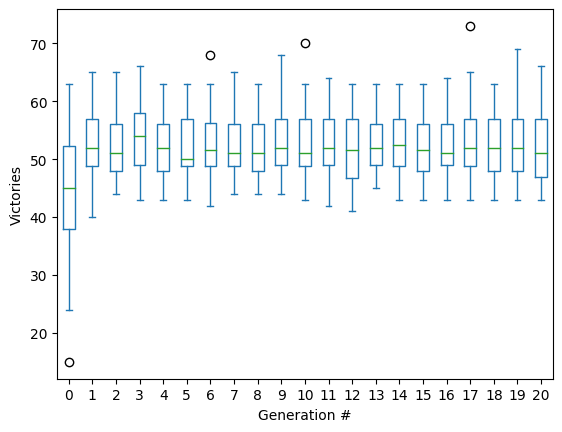

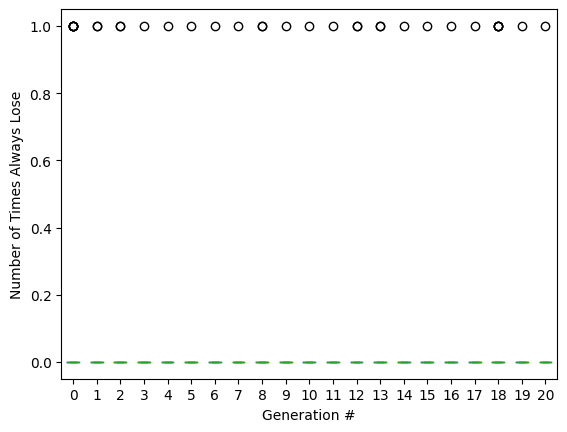

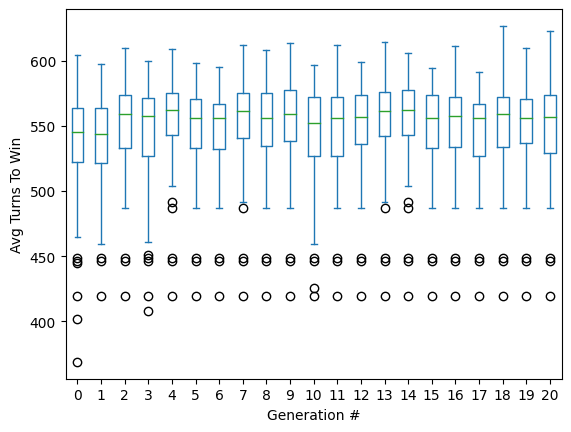

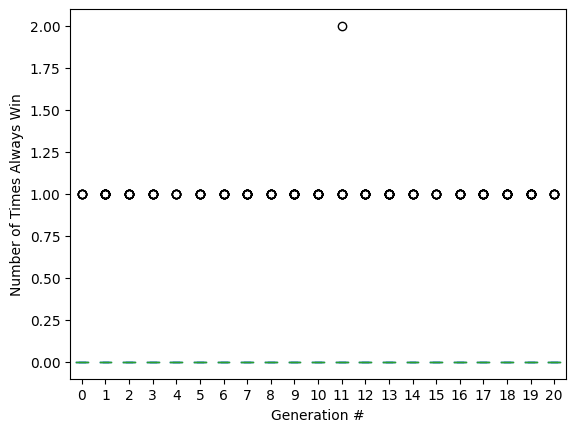

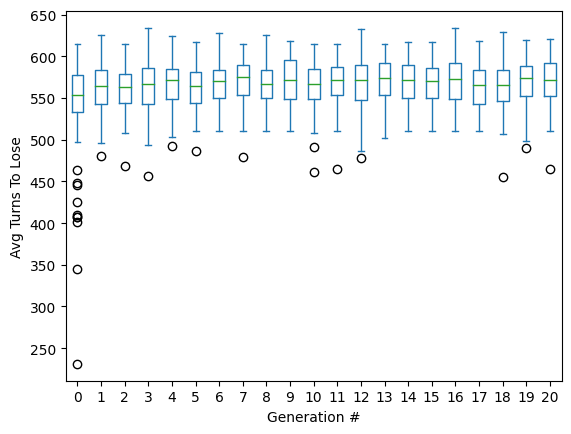

In [41]:
# box whisker seperated by generation and dimension
y_axes = ["Victories", "Number of Times Always Lose", "Avg Turns To Win", "Number of Times Always Win", "Avg Turns To Lose"]
for d in range(len(seperated)):

    ax = seperated[d].T.plot.box()
    ax.set_xlabel("Generation #")
    ax.set_ylabel(y_axes[d])

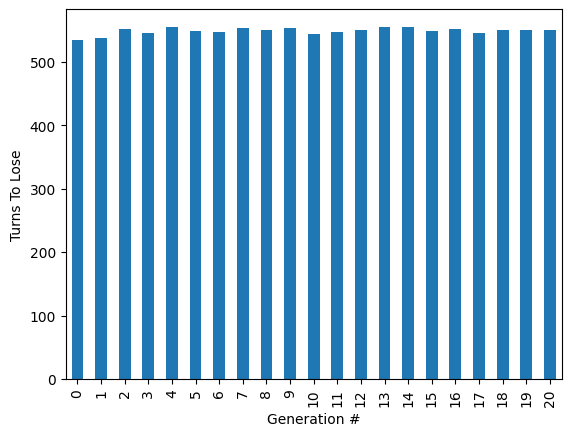

In [42]:
# box whisker seperated by generation and dimension
y_axes = ["Victories", "Number of Times Always Lose", "Turns To Win", "Number of Times Always Win", "Turns To Lose"]
for d in range(len(seperated)):

    ax = seperated[2].T.mean().plot.bar()
    ax.set_xlabel("Generation #")
    ax.set_ylabel(y_axes[d])